In [ ]:
import os
from ipaddress import AddressValueError, ip_address

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Input
from tensorflow.keras.models import Model

In [10]:
def load_data(file_path):
    all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.csv')]
    df_list = []

    for file in all_files:
        df = pd.read_csv(file, encoding='latin1')
        df.columns = df.columns.str.strip()
        df_list.append(df)
    
    return df_list


def is_private_ip(ip):
    # NaN 값이거나 문자열이 아닌 경우를 먼저 확인하여 처리
    if not isinstance(ip, str):
        return False
    
    try:
        return ip_address(ip).is_private
    except AddressValueError:
        return False


def preprocess_data(df_list):
    full_df = pd.concat(df_list, ignore_index=True)

    # 시간에 대한 정보인 Timestamp 컬럼을 datetime 형식으로 변환하고, 시간과 요일 정보를 추출
    full_df['Timestamp'] = pd.to_datetime(full_df['Timestamp'], errors='coerce')
    full_df['Hour'] = full_df['Timestamp'].dt.hour
    full_df['DayOfWeek'] = full_df['Timestamp'].dt.dayofweek
    
    # is_private_ip 함수를 적용하여 사설 IP 여부를 1과 0으로 변환
    full_df['Src_IP_is_Private'] = full_df['Source IP'].apply(is_private_ip).astype(int)
    full_df['Dst_IP_is_Private'] = full_df['Destination IP'].apply(is_private_ip).astype(int)
    
    # 불필요한 컬럼 제거
    full_df = full_df.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'])
    
    # 무한대 값을 NaN으로 바꾸고, NaN 및 누락 값 포함 행 제거
    full_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    full_df.dropna(inplace=True)
    
    # 숫자형 feature만 선택
    numeric_cols = full_df.select_dtypes(include=np.number).columns.tolist()
    
    # 정상/공격 데이터 분리
    benign_df = full_df[full_df['Label'] == 'BENIGN']
    attack_df = full_df[full_df['Label'] != 'BENIGN']
    
    # 스케일링
    scaler = MinMaxScaler()
    benign_scaled = scaler.fit_transform(benign_df[numeric_cols])
    attack_scaled = scaler.transform(attack_df[numeric_cols])

    return benign_scaled, attack_scaled

data_path = 'dataset/'
df_list = load_data(data_path)
benign_data, attack_data = preprocess_data(df_list)
X_train, X_val = train_test_split(benign_data, test_size=0.2, random_state=42)


C:\Users\bell1\AppData\Local\Temp\ipykernel_13116\3806497592.py:6: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding='latin1')


In [16]:
input_dim = X_train.shape[1] # 전처리 후 데이터의 특성 수

# Input Layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoder = Dense(128, activation='relu')(input_layer)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(64, activation='relu')(encoder)
encoder = BatchNormalization()(encoder)
encoder = Dropout(0.2)(encoder)

bottleneck = Dense(32, activation='relu')(encoder)

# Decoder
decoder = Dense(64, activation='relu')(bottleneck)
decoder = BatchNormalization()(decoder)

decoder = Dense(128, activation='relu')(decoder)
decoder = BatchNormalization()(decoder)

# Output Layer
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

history = autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=4, batch_size=256)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        10,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 84)             │        10,836 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,020 (171.95 KB)

 Trainable params: 43,252 (168.95 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/4
5444/5444 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - loss: 0.0194 - val_loss: 3.6529e-04
Epoch 2/4
5444/5444 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 6.0319e-04 - val_loss: 1.7167e-04
Epoch 3/4
5444/5444 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 3.9686e-04 - val_loss: 1.4311e-04
Epoch 4/4
5444/5444 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - loss: 3.0600e-04 - val_loss: 1.1516e-04


In [17]:
benign_pred = autoencoder.predict(benign_data)
attack_pred = autoencoder.predict(attack_data)

54433/54433 ━━━━━━━━━━━━━━━━━━━━ 44s 815us/step
17393/17393 ━━━━━━━━━━━━━━━━━━━━ 21s 1ms/step


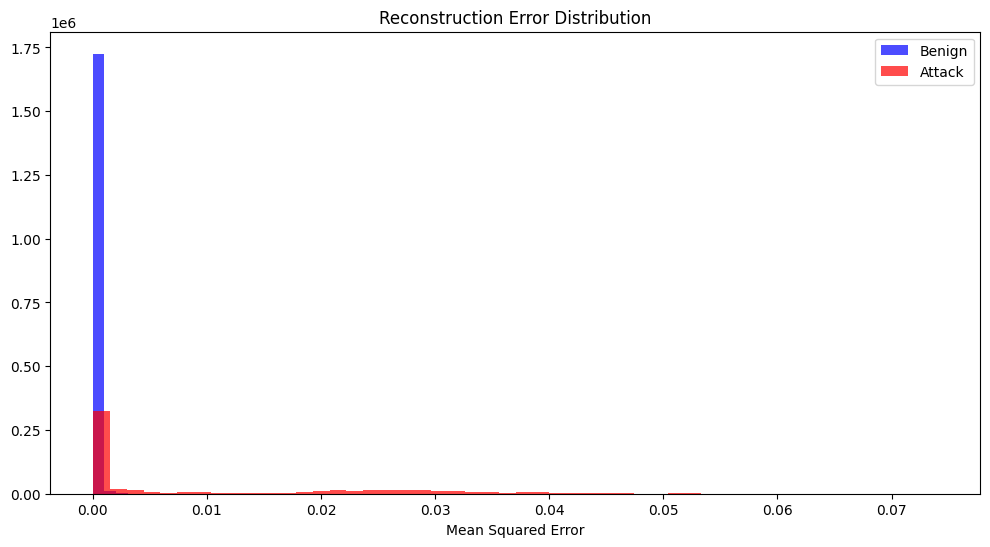

In [18]:
## Reconstruction Error
benign_mse = np.mean(np.power(benign_data - benign_pred, 2), axis=1)
attack_mse = np.mean(np.power(attack_data - attack_pred, 2), axis=1)

plt.figure(figsize=(12, 6))
plt.hist(benign_mse, bins=50, color='blue', alpha=0.7, label='Benign')
plt.hist(attack_mse, bins=50, color='red', alpha=0.7, label='Attack')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.xlabel('Mean Squared Error')
plt.show()

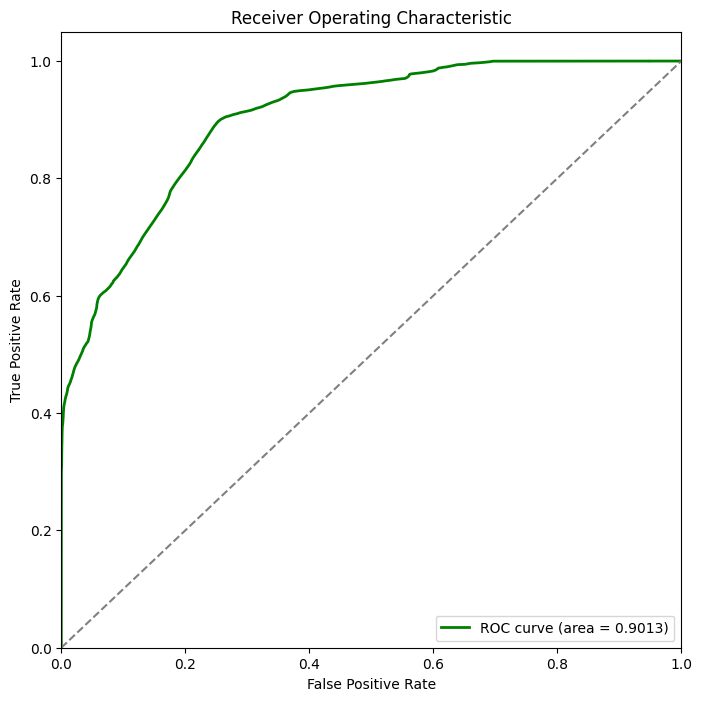

In [19]:
## ROC curve
true_labels = np.concatenate([np.zeros(len(benign_mse)), np.ones(len(attack_mse))])
pred_scores = np.concatenate([benign_mse, attack_mse])

fpr, tpr, thresholds = roc_curve(true_labels, pred_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='green', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()